In [1]:
import numpy as np
import glob
import json
from tqdm.notebook import tqdm

from skimage import color

from utils import grainPreprocess, grainShow, grainMark, grainDraw, grainApprox, grainStats, grainMorphology,grainGenerate, SEMDataset

from crdp import rdp
from skimage import io, filters, morphology, util
from torch.utils.data import Dataset

from matplotlib import pyplot as plt
import os
from pathlib import Path
import json

## Углы

In [4]:
def angles_approx_save(images_path, save_path, types_dict, step, max_images_num_per_class=None, no_cache=False):

    #
    # вычисление и сохранение распределения углов для всех фотографий одного образца
    #

    json_data = []
    
    dataset = SEMDataset(images_path, no_cache=no_cache, max_images_num_per_class=max_images_num_per_class)
    shape=dataset.images_paths.shape
    
    pbar = tqdm(total=shape[0]*shape[1])

    for i in range(dataset.images_paths.shape[0]):
        all_angles = []
        
        for j in range(dataset.images_paths.shape[1]):
            image, path = dataset.__getitem__(i,j)
            ang=grainMark.get_angles(image)
            all_angles.extend(ang)
            pbar.update(1)

        x, y = grainStats.stats_preprocess(all_angles, step)

        (x_gauss, y_gauss), mus, sigmas, amps = grainApprox.bimodal_gauss_approx(x, y)
        name = path.split('/')[-2]

        text = grainGenerate.angles_legend(dataset.images_paths.shape[1], types_dict[name], types_dict[name], step, mus, sigmas,amps, len(all_angles) )
        
        path='/'.join(path.split('/')[:-1])

        json_data.append({'path': path,
                          'name': name,
                          'type': types_dict[name],
                          'legend': text,
                          'density_curve_scatter': [x,y],
                          'gauss_approx_plot': [x_gauss, y_gauss],
                          'gauss_approx_data': {'mus': mus, 'sigmas':sigmas, 'amps':amps},
                          })

    with open(f'{save_path}_step_{step}_angles.json', 'w', encoding='utf-8') as outfile:
        json.dump(json_data, outfile, cls=grainGenerate.NumpyEncoder, ensure_ascii=False)

  0%|          | 0/100 [00:00<?, ?it/s]

/mnt/d/python/wc_cv/cv/utils.py:91: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  image = self.preprocess_image(image)
/home/david/anaconda3/envs/torch/lib/python3.11/site-packages/skimage/util/dtype.py:576: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  return _convert(image, np.uint8, force_copy)


  0%|          | 0/100 [00:00<?, ?it/s]

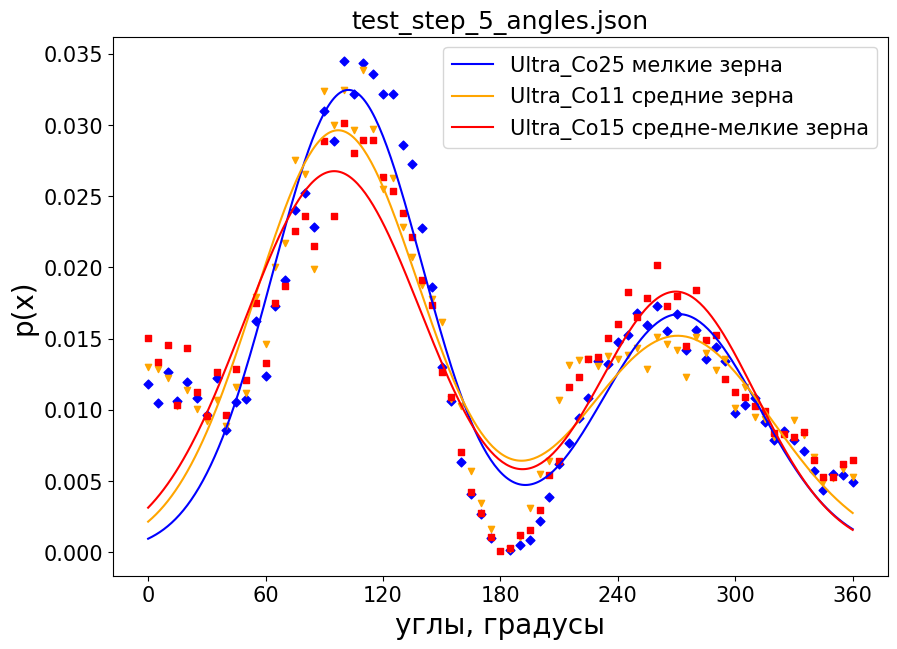

--------------
мелкие зерна мелкие зерна
 количество углов 43805
 количество снимков 20
 шаг угла 5 градусов
 mu1 = 102.28 sigma1 = 38.47 amp1 = 3.13
 mu2 = 271.3 sigma2 = 41.04 amp2 = 1.72
--------------
средние зерна средние зерна
 количество углов 16136
 количество снимков 20
 шаг угла 5 градусов
 mu1 = 96.97 sigma1 = 42.33 amp1 = 3.14
 mu2 = 270.63 sigma2 = 48.35 amp2 = 1.84
--------------
средне-мелкие зерна средне-мелкие зерна
 количество углов 29138
 количество снимков 20
 шаг угла 5 градусов
 mu1 = 95.06 sigma1 = 45.88 amp1 = 3.08
 mu2 = 269.71 sigma2 = 40.73 amp2 = 1.87
CPU times: user 25.6 s, sys: 582 ms, total: 26.1 s
Wall time: 28.2 s


In [14]:
%%time

step = 5

# images_path = '../ml/diffusion/data/o_bc_left_4x_768_360_768_median_generated'
# images_path = '../ml/diffusion/data/o_bc_left_4x_768_360_512_median_generated'
# images_path = '../ml/diffusion/data/o_bc_left_4x_768_360_256_median_generated'

images_path = '../datasets/original/o_bc_left_4x_768'

# save_path = 'o_bc_left_4x_768_360_median_generated_preprocess'
# save_path = 'o_bc_left_4x_768_360_256_median_generated_preprocess'
# save_path = 'o_bc_left_4x_768_360_768_median_generated'
save_path = 'test'

types_dict = {'Ultra_Co11': 'средние зерна',
              'Ultra_Co25': 'мелкие зерна',
              'Ultra_Co8': 'средне-мелкие зерна',
              'Ultra_Co6_2': 'крупные зерна',
              'Ultra_Co15': 'средне-мелкие зерна'}

angles_approx_save(
                    images_path=images_path,
                    save_path=save_path,
                    types_dict=types_dict,
                    step=step,
                    max_images_num_per_class=20, 
                    no_cache=True
                )

file_name=f'{save_path}_step_{step}_angles.json'

data = open(file_name,encoding='utf-8')
data = json.load(data)

grainShow.angles_plot_base(data,save_name=file_name, step=step, N=10, M=7, indices=[2,0,1], save=False)

## Полуоси

In [2]:
pixel = 50 / 1000

# images_path = '../ml/diffusion/data/o_bc_left_4x_768_360_768_median_generated'
# images_path = '../ml/diffusion/data/o_bc_left_4x_768_360_512_median_generated'
images_path = '../ml/diffusion/data/o_bc_left_4x_768_360_256_median_generated'

save_path = 'o_bc_left_4x_768_360_256_median_generated'


types_dict = {'Ultra_Co11': 'средние зерна',
              'Ultra_Co25': 'мелкие зерна',
              'Ultra_Co8': 'средне-мелкие зерна',
              'Ultra_Co6_2': 'крупные зерна',
              'Ultra_Co15': 'средне-мелкие зерна'}


for step in range(5, 6):
    grainGenerate.diametr_approx_save(
    # diametr_approx_save(
                        images_path=images_path,
                        save_path=save_path,
                        types_dict=types_dict,
                        step=step,
                        max_images_num_per_class=None, 
                        no_cache=False,
                        pixel = pixel
    )

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

# Прочее

In [ ]:
images = np.load('images_7_classes_mixer_preprocess.npy')
names = np.load('metadata_7_classes_mixer_preprocess.npy')
names = [name.split('\\')[-1] for name in names]

folder = 'data/'

types_dict = {'2550-51': '2550 призм, кадр 51\n доля карбина 54.51%',
              '2550-52': '2550 призм, кадр 52\n доля карбина 50.75%',
              '2550-53': '2550 призм, кадр 53\n доля карбина 45.81%',
              '3400-51': '3400 призм, кадр 51\n доля карбина 53.53%',
              '3400-52': '3400 призм, кадр 52\n доля карбина 50.47%',
              '3400-53': '3400 призм, кадр 53\n доля карбина 45.88%',
              '3400-54': '3400 призм, кадр 54\n доля карбина 40.88%'}

dens_dict={'2550-51': 0.5451066158234127,
           '2550-52': 0.5075556821469908,
           '2550-53': 0.4580166661499669,
           '3400-51': 0.535331783234127,
           '3400-52': 0.504782962859623,
           '3400-53': 0.45885131190062833,
           '3400-54': 0.40882115988756607}

